<a href="https://colab.research.google.com/github/OhMinSuk/KBO-Ensemble-Learning/blob/main/%EC%95%99%EC%83%81%EB%B8%94_%EA%B8%B0%EB%B2%95%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_KBO%EA%B4%80%EC%A4%91_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8_%EA%B0%9C%EB%B0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 초기 예측 모델

데이터 로드 중...

=== 결측값 분석 ===
                  Missing Values  Missing Ratio (%)
day                          599          12.236977
stadium                      599          12.236977
home_or_away                 599          12.236977
attendance                  2746          56.098059
attendance_ratio            2751          56.200204

데이터 전처리 중...

원본 데이터 shape: (4895, 11)
attendance_ratio 결측값 제거 후 shape: (2144, 11)

전처리 후 결측값 여부:
rank                0
win_rate            0
streak_value        0
search_value        0
day_encoded         0
team_encoded        0
stadium_encoded     0
is_home             0
attendance_ratio    0
dtype: int64

학습/테스트 데이터 분할 중...

=== Linear Regression 학습 중 ===
RMSE: 23.23
R2 Score: 0.207

=== Decision Tree 학습 중 ===


<ipython-input-22-1c09c24bb28c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
<ipython-input-22-1c09c24bb28c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
<ipython-input-22-1c09c24bb28c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

RMSE: 22.48
R2 Score: 0.257

=== Random Forest 학습 중 ===
OOB Score: 0.559
RMSE: 16.99
R2 Score: 0.576

=== XGBoost 학습 중 ===
RMSE: 17.45
R2 Score: 0.552


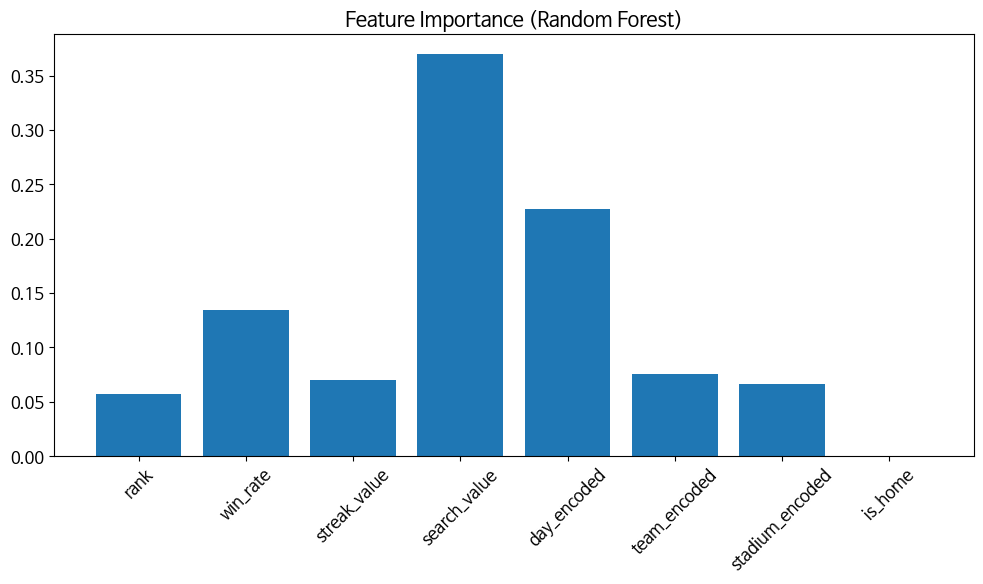

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_missing_values(df):
    # 결측값 개수와 비율 확인
    missing_values = df.isnull().sum()
    missing_ratio = (missing_values / len(df)) * 100

    missing_info = pd.DataFrame({
        'Missing Values': missing_values,
        'Missing Ratio (%)': missing_ratio
    })

    print("\n=== 결측값 분석 ===")
    print(missing_info[missing_info['Missing Values'] > 0])
    return missing_info

def preprocess_data(df):
    # 결측값 처리
    print("\n원본 데이터 shape:", df.shape)

    # attendance_ratio가 있는 데이터만 선택 (실제 경기가 열린 경우)
    df = df.dropna(subset=['attendance_ratio'])
    print("attendance_ratio 결측값 제거 후 shape:", df.shape)

    # search_value 결측값 처리 (중앙값으로 대체)
    if df['search_value'].isnull().any():
        df['search_value'] = df['search_value'].fillna(df['search_value'].median())

    # 범주형 변수 전처리
    le = LabelEncoder()
    for col in ['day', 'team', 'stadium']:
        if col in df.columns:
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))

    # 연승/연패 수치 변환
    df['streak_value'] = df['streak'].apply(lambda x:
        int(x[:-1]) if x.endswith('승') else -int(x[:-1]))

    # home/away 더미 변수화
    df['is_home'] = (df['home_or_away'] == 'home').astype(int)

    # 피처 선택
    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    # 최종 확인
    print("\n전처리 후 결측값 여부:")
    print(df[features + ['attendance_ratio']].isnull().sum())

    return df, features

def train_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, oob_score = True),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
    }

    results = {}

    for name, model in models.items():
        print(f"\n=== {name} 학습 중 ===")
        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 평가 지표 계산
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # 교차 검증
        cv_scores = cross_val_score(model, X_train, y_train,
                                  cv=5, scoring='r2')

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'CV_R2_mean': cv_scores.mean(),
            'CV_R2_std': cv_scores.std(),
            'model': model
        }
        if name == 'Random Forest':
            oob_score = model.oob_score_
            results[name]['OOB_Score'] = oob_score
            print(f"OOB Score: {oob_score:.3f}")

        if name == 'Linear Regression':
            importance = np.abs(model.coef_)
        else:
            importance = model.feature_importances_

        results[name]['feature_importance'] = importance

        print(f"RMSE: {rmse:.2f}")
        print(f"R2 Score: {r2:.3f}")

    return results

def main():
    # 데이터 로드
    print("데이터 로드 중...")
    df = pd.read_csv('/content/24KBO데이터최종종.csv')

    # 결측값 분석
    missing_info = analyze_missing_values(df)

    # 데이터 전처리
    print("\n데이터 전처리 중...")
    df, features = preprocess_data(df)

    # 피처와 타겟 분리
    X = df[features]
    y = df['attendance_ratio']

    print("\n학습/테스트 데이터 분할 중...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 모델 학습 및 평가
    results = train_models(X_train_scaled, X_test_scaled, y_train, y_test)

    # 특성 중요도 시각화 (Random Forest 기준)
    plt.figure(figsize=(10, 6))
    importance = results['Random Forest']['feature_importance']
    plt.bar(features, importance)
    plt.title('Feature Importance (Random Forest)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def calculate_expected_attendance_ratio(df):
    """전체 데이터프레임에 대해 expected_attendance_ratio를 계산"""
    # 결과를 저장할 새로운 컬럼 생성
    df['expected_attendance_ratio'] = np.nan

    # 날짜별로 처리
    for date in df['date'].unique():
        date_games = df[df['date'] == date]

        # 각 구장에서 열린 경기 처리
        for stadium in date_games['stadium'].dropna().unique():
            stadium_games = date_games[date_games['stadium'] == stadium]

            # 홈팀 찾기
            home_game = stadium_games[stadium_games['home_or_away'] == 'home']
            if len(home_game) > 0:
                home_ratio = home_game['attendance_ratio'].iloc[0]

                # 홈팀 비율 설정
                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'home'),
                      'expected_attendance_ratio'] = home_ratio

                # 원정팀 비율 설정 (홈팀 비율의 30%)
                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'away'),
                      'expected_attendance_ratio'] = home_ratio * 0.3

    return df

def preprocess_data(df):
    print("\n=== 데이터 전처리 현황 ===")
    print(f"원본 데이터: {len(df)}행")

    # 월요일 데이터 제외
    df = df[df['day'] != '월']
    print(f"월요일 제외 후: {len(df)}행")

    # 새로운 관중 비율 계산
    df = calculate_expected_attendance_ratio(df)

    # NULL 제거
    df = df.dropna(subset=['expected_attendance_ratio'])
    print(f"NULL 제외 후: {len(df)}행")

    # 범주형 변수 전처리
    le = LabelEncoder()
    df['day_encoded'] = le.fit_transform(df['day'])
    df['team_encoded'] = le.fit_transform(df['team'])
    df['stadium_encoded'] = le.fit_transform(df['stadium'])

    # 연승/연패 수치 변환
    df['streak_value'] = df['streak'].apply(lambda x:
        int(x[:-1]) if x.endswith('승') else -int(x[:-1]))

    # home/away 더미 변수화
    df['is_home'] = (df['home_or_away'] == 'home').astype(int)

    return df

def train_model(df):
    # 피처 선택
    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    X = df[features]
    y = df['expected_attendance_ratio']

    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest 모델 학습
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # 예측 및 성능 평가
    y_pred = rf_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("\n=== 모델 성능 ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.3f}")

    # 특성 중요도 분석
    importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n=== 특성 중요도 ===")
    print(importance)

    return rf_model, importance

def analyze_home_away_patterns(df):
    print("\n=== 홈/원정 관중 비율 분석 ===")
    print("\n홈/원정별 평균 관중 비율:")
    print(df.groupby('home_or_away')['expected_attendance_ratio'].mean())

    print("\n팀별 홈/원정 평균 관중 비율:")
    print(df.groupby(['team', 'home_or_away'])['expected_attendance_ratio'].mean().unstack())

def main():
    # 데이터 로드
    df = pd.read_csv('/content/24KBO데이터최종종.csv')

    # 데이터 전처리
    df_processed = preprocess_data(df)

    # 홈/원정 패턴 분석
    analyze_home_away_patterns(df_processed)

    # 모델 학습
    model, importance = train_model(df_processed)

    # 기본 통계량
    print("\n=== 기본 통계량 ===")
    print(df_processed['expected_attendance_ratio'].describe())

if __name__ == "__main__":
    main()


=== 데이터 전처리 현황 ===
원본 데이터: 4895행
월요일 제외 후: 4847행


<ipython-input-4-81b77c8c887b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expected_attendance_ratio'] = np.nan


NULL 제외 후: 4228행

=== 홈/원정 관중 비율 분석 ===

홈/원정별 평균 관중 비율:
home_or_away
away    16.727846
home    55.797170
Name: expected_attendance_ratio, dtype: float64

팀별 홈/원정 평균 관중 비율:
home_or_away       away       home
team                              
KIA           20.529384  58.028302
KT            13.163033  49.500000
LG            17.158852  64.794393
NC            14.301951  43.075472
SSG           14.567143  64.369668
두산            16.814085  53.549296
롯데            20.112919  57.084112
삼성            17.876056  56.562791
키움            14.620755  50.042056
한화            18.064186  61.078049

=== 모델 성능 ===
RMSE: 12.11
R2 Score: 0.807

=== 특성 중요도 ===
           feature  importance
7          is_home    0.502491
3     search_value    0.187030
4      day_encoded    0.109866
1         win_rate    0.065733
5     team_encoded    0.039675
2     streak_value    0.033874
6  stadium_encoded    0.031751
0             rank    0.029581

=== 기본 통계량 ===
count    4228.000000
mean       36.317952
std        

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def calculate_expected_attendance_ratio(df):
    """전체 데이터프레임에 대해 expected_attendance_ratio를 계산"""
    # 결과를 저장할 새로운 컬럼 생성
    df['expected_attendance_ratio'] = np.nan

    # 날짜별로 처리
    for date in df['date'].unique():
        date_games = df[df['date'] == date]

        # 각 구장에서 열린 경기 처리
        for stadium in date_games['stadium'].dropna().unique():
            stadium_games = date_games[date_games['stadium'] == stadium]

            # 홈팀 찾기
            home_game = stadium_games[stadium_games['home_or_away'] == 'home']
            if len(home_game) > 0:
                total_ratio = home_game['attendance_ratio'].iloc[0]

                # 홈팀 비율 설정 (전체의 70%)
                home_ratio = total_ratio * 0.7
                # 원정팀 비율 설정 (전체의 30%)
                away_ratio = total_ratio * 0.3

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'home'),
                      'expected_attendance_ratio'] = home_ratio

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'away'),
                      'expected_attendance_ratio'] = away_ratio

    return df

def preprocess_data(df):
    print("\n=== 데이터 전처리 현황 ===")
    print(f"원본 데이터: {len(df)}행")

    # 월요일 데이터 제외
    df = df[df['day'] != '월']
    print(f"월요일 제외 후: {len(df)}행")

    # 새로운 관중 비율 계산
    df = calculate_expected_attendance_ratio(df)

    # NULL 제거
    df = df.dropna(subset=['expected_attendance_ratio'])
    print(f"NULL 제외 후: {len(df)}행")

    # 범주형 변수 전처리
    le = LabelEncoder()
    df['day_encoded'] = le.fit_transform(df['day'])
    df['team_encoded'] = le.fit_transform(df['team'])
    df['stadium_encoded'] = le.fit_transform(df['stadium'])

    # 연승/연패 수치 변환
    df['streak_value'] = df['streak'].apply(lambda x:
        int(x[:-1]) if x.endswith('승') else -int(x[:-1]))

    # home/away 더미 변수화
    df['is_home'] = (df['home_or_away'] == 'home').astype(int)

    return df

def train_model(df):
    # 피처 선택
    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    X = df[features]
    y = df['expected_attendance_ratio']

    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest 모델 학습
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # 예측 및 성능 평가
    y_pred = rf_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("\n=== 모델 성능 ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.3f}")

    # 특성 중요도 분석
    importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n=== 특성 중요도 ===")
    print(importance)

    return rf_model, importance

def analyze_home_away_patterns(df):
    print("\n=== 홈/원정 관중 비율 분석 ===")
    print("\n홈/원정별 평균 관중 비율:")
    print(df.groupby('home_or_away')['expected_attendance_ratio'].mean())

    print("\n팀별 홈/원정 평균 관중 비율:")
    print(df.groupby(['team', 'home_or_away'])['expected_attendance_ratio'].mean().unstack())

def main():
    # 데이터 로드
    df = pd.read_csv('24KBO데이터최종종.csv')

    # 데이터 전처리
    df_processed = preprocess_data(df)

    # 홈/원정 패턴 분석
    analyze_home_away_patterns(df_processed)

    # 모델 학습
    model, importance = train_model(df_processed)

    # 기본 통계량
    print("\n=== 기본 통계량 ===")
    print(df_processed['expected_attendance_ratio'].describe())

    # 결과를 CSV 파일로 저장
    output_filename = '24KBO데이터_7대3비율.csv'
    df_processed.to_csv(output_filename, index=False, encoding='utf-8-sig')
    print(f"\n데이터가 {output_filename}로 저장되었습니다.")

if __name__ == "__main__":
    main()


=== 데이터 전처리 현황 ===
원본 데이터: 4895행
월요일 제외 후: 4847행


<ipython-input-24-6a67429d132c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expected_attendance_ratio'] = np.nan


NULL 제외 후: 4228행

=== 홈/원정 관중 비율 분석 ===

홈/원정별 평균 관중 비율:
home_or_away
away    16.727846
home    39.058019
Name: expected_attendance_ratio, dtype: float64

팀별 홈/원정 평균 관중 비율:
home_or_away       away       home
team                              
KIA           20.529384  40.619811
KT            13.163033  34.650000
LG            17.158852  45.356075
NC            14.301951  30.152830
SSG           14.567143  45.058768
두산            16.814085  37.484507
롯데            20.112919  39.958879
삼성            17.876056  39.593953
키움            14.620755  35.029439
한화            18.064186  42.754634

=== 모델 성능 ===
RMSE: 8.86
R2 Score: 0.759

=== 특성 중요도 ===
           feature  importance
7          is_home    0.383359
3     search_value    0.233553
4      day_encoded    0.135386
1         win_rate    0.081401
5     team_encoded    0.047908
6  stadium_encoded    0.041067
2     streak_value    0.040953
0             rank    0.036374

=== 기본 통계량 ===
count    4228.000000
mean       27.924622
std        1

# 개선 예측 모델


=== 데이터 전처리 현황 ===
원본 데이터: 4895행
월요일 제외 후: 4847행


<ipython-input-25-49e2b7626d32>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expected_attendance_ratio'] = np.nan


NULL 제외 후: 4228행

=== Linear Regression 학습 중 ===
RMSE: 12.79
MAE: 9.98
R2 Score: 0.497
CV R2 Score: 0.496 (+/- 0.051)

=== Ridge 학습 중 ===
RMSE: 12.79
MAE: 9.98
R2 Score: 0.497
CV R2 Score: 0.496 (+/- 0.051)

=== Lasso 학습 중 ===
RMSE: 13.02
MAE: 10.17
R2 Score: 0.479
CV R2 Score: 0.481 (+/- 0.036)

=== ElasticNet 학습 중 ===
RMSE: 13.65
MAE: 10.68
R2 Score: 0.427
CV R2 Score: 0.428 (+/- 0.025)

=== Random Forest 학습 중 ===
RMSE: 8.86
MAE: 6.46
R2 Score: 0.759
CV R2 Score: 0.729 (+/- 0.034)

=== XGBoost 학습 중 ===
RMSE: 8.84
MAE: 6.43
R2 Score: 0.760
CV R2 Score: 0.730 (+/- 0.037)

=== LightGBM 학습 중 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 3382, number of used features: 8
[LightGBM] [Info] Start training from score 27.828119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

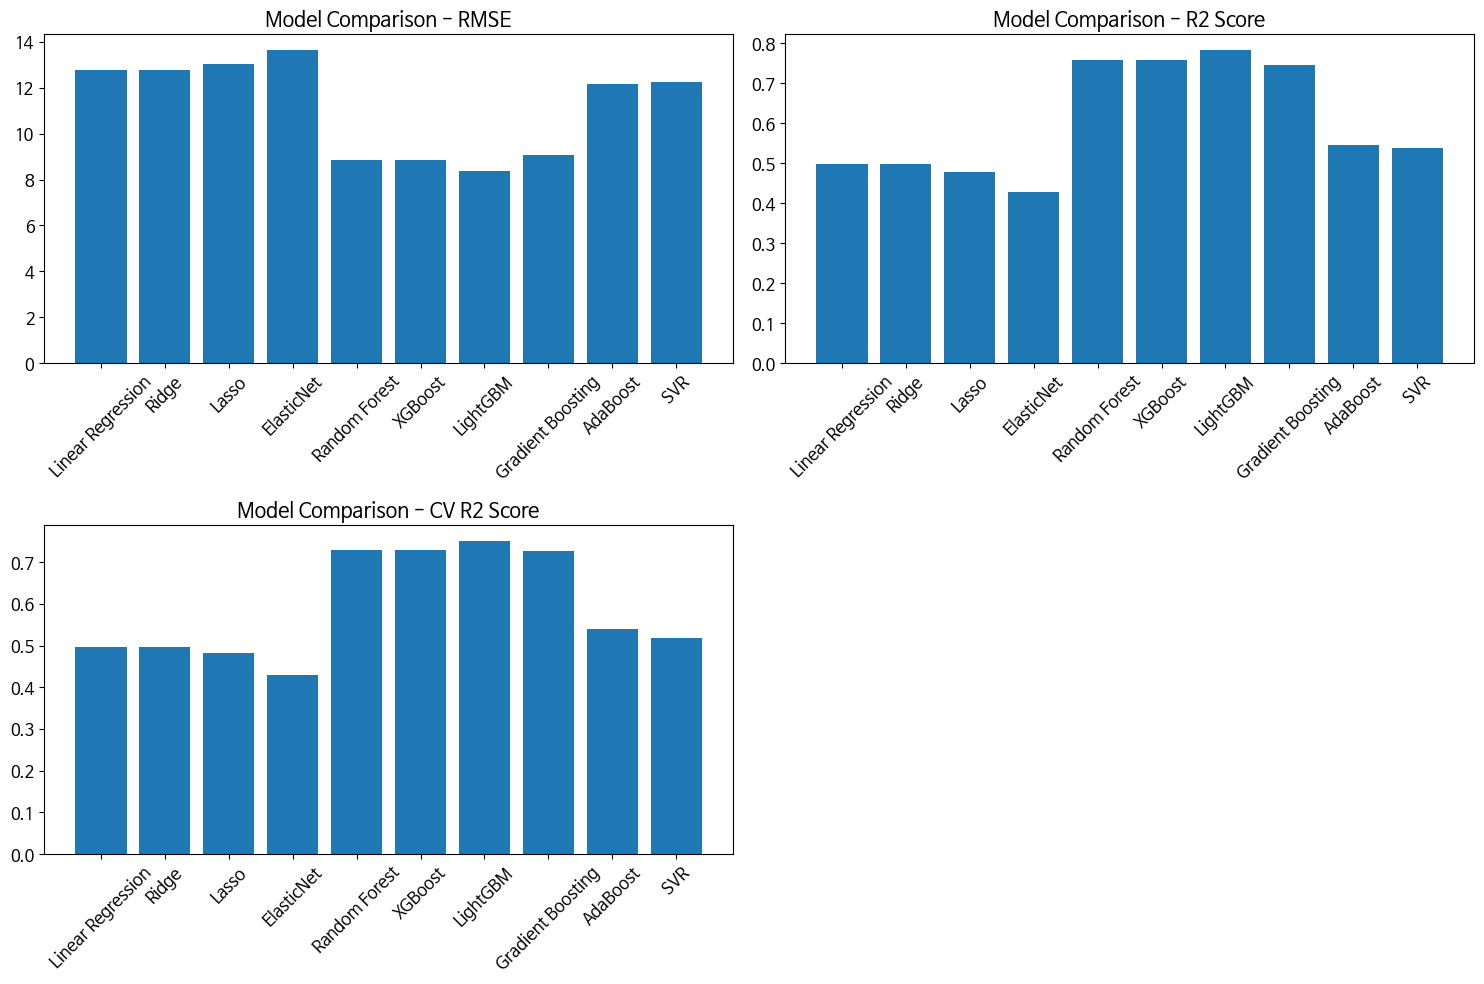

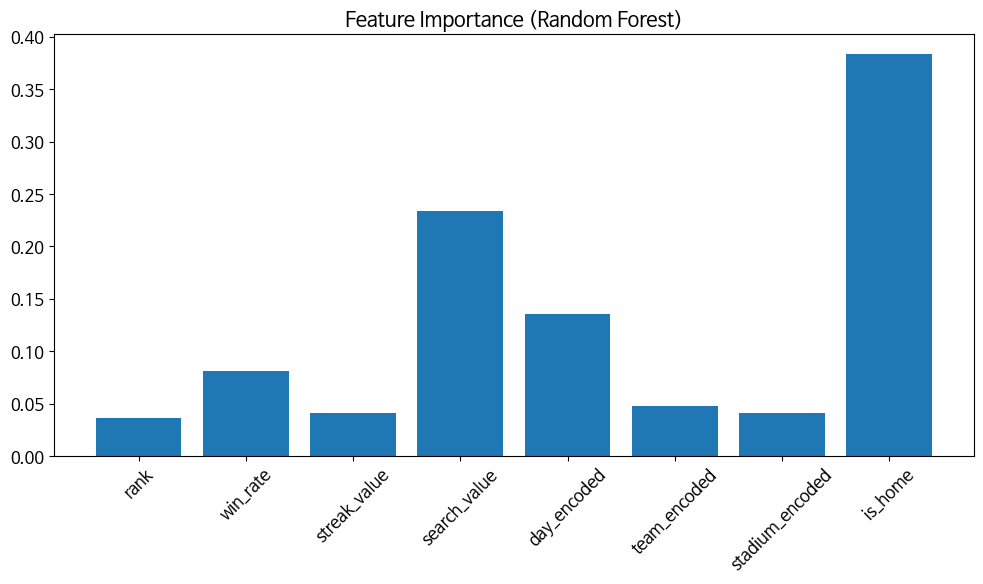

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_expected_attendance_ratio(df):
    """전체 데이터프레임에 대해 expected_attendance_ratio를 계산"""
    df['expected_attendance_ratio'] = np.nan

    for date in df['date'].unique():
        date_games = df[df['date'] == date]

        for stadium in date_games['stadium'].dropna().unique():
            stadium_games = date_games[date_games['stadium'] == stadium]

            home_game = stadium_games[stadium_games['home_or_away'] == 'home']
            if len(home_game) > 0:
                total_ratio = home_game['attendance_ratio'].iloc[0]

                # 홈팀 비율 설정 (전체의 70%)
                home_ratio = total_ratio * 0.7
                # 원정팀 비율 설정 (전체의 30%)
                away_ratio = total_ratio * 0.3

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'home'),
                      'expected_attendance_ratio'] = home_ratio

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'away'),
                      'expected_attendance_ratio'] = away_ratio

    return df

def preprocess_data(df):
    print("\n=== 데이터 전처리 현황 ===")
    print(f"원본 데이터: {len(df)}행")

    # 월요일 데이터 제외
    df = df[df['day'] != '월']
    print(f"월요일 제외 후: {len(df)}행")

    # 새로운 관중 비율 계산
    df = calculate_expected_attendance_ratio(df)

    # NULL 제거
    df = df.dropna(subset=['expected_attendance_ratio'])
    print(f"NULL 제외 후: {len(df)}행")

    # 범주형 변수 전처리
    le = LabelEncoder()
    df['day_encoded'] = le.fit_transform(df['day'])
    df['team_encoded'] = le.fit_transform(df['team'])
    df['stadium_encoded'] = le.fit_transform(df['stadium'])

    # 연승/연패 수치 변환
    df['streak_value'] = df['streak'].apply(lambda x:
        int(x[:-1]) if x.endswith('승') else -int(x[:-1]))

    # home/away 더미 변수화
    df['is_home'] = (df['home_or_away'] == 'home').astype(int)

    return df

def train_multiple_models(X_train, X_test, y_train, y_test, features):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf')
    }

    results = {}

    for name, model in models.items():
        print(f"\n=== {name} 학습 중 ===")

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 평가 지표 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # 교차 검증
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'CV_R2_mean': cv_scores.mean(),
            'CV_R2_std': cv_scores.std()
        }

        # 특성 중요도 (가능한 모델의 경우)
        if hasattr(model, 'feature_importances_'):
            results[name]['feature_importance'] = model.feature_importances_
        elif hasattr(model, 'coef_'):
            results[name]['feature_importance'] = np.abs(model.coef_)

        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R2 Score: {r2:.3f}")
        print(f"CV R2 Score: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

    return results

def visualize_results(results, features):
    # 모델별 성능 비교 그래프
    plt.figure(figsize=(15, 10))

    # RMSE 비교
    plt.subplot(2, 2, 1)
    rmse_values = [results[model]['RMSE'] for model in results.keys()]
    plt.bar(results.keys(), rmse_values)
    plt.title('Model Comparison - RMSE')
    plt.xticks(rotation=45)

    # R2 Score 비교
    plt.subplot(2, 2, 2)
    r2_values = [results[model]['R2'] for model in results.keys()]
    plt.bar(results.keys(), r2_values)
    plt.title('Model Comparison - R2 Score')
    plt.xticks(rotation=45)

    # Cross-validation R2 비교
    plt.subplot(2, 2, 3)
    cv_r2_values = [results[model]['CV_R2_mean'] for model in results.keys()]
    plt.bar(results.keys(), cv_r2_values)
    plt.title('Model Comparison - CV R2 Score')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


def main():
    # 데이터 로드
    df = pd.read_csv('/content/24KBO데이터최종종.csv')

    # 데이터 전처리
    df = preprocess_data(df)

    # 피처와 타겟 분리
    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    X = df[features]
    y = df['expected_attendance_ratio']

    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 여러 모델 학습 및 평가
    results = train_multiple_models(X_train_scaled, X_test_scaled, y_train, y_test, features)

    # 결과 시각화
    visualize_results(results, features)

if __name__ == "__main__":
    main()

LightGBM

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import shap

def calculate_expected_attendance_ratio(df):
    """전체 데이터프레임에 대해 expected_attendance_ratio를 계산"""
    df['expected_attendance_ratio'] = np.nan

    for date in df['date'].unique():
        date_games = df[df['date'] == date]

        for stadium in date_games['stadium'].dropna().unique():
            stadium_games = date_games[date_games['stadium'] == stadium]

            home_game = stadium_games[stadium_games['home_or_away'] == 'home']
            if len(home_game) > 0:
                total_ratio = home_game['attendance_ratio'].iloc[0]

                # 홈팀 비율 설정 (전체의 70%)
                home_ratio = total_ratio * 0.7
                # 원정팀 비율 설정 (전체의 30%)
                away_ratio = total_ratio * 0.3

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'home'),
                      'expected_attendance_ratio'] = home_ratio

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'away'),
                      'expected_attendance_ratio'] = away_ratio

    return df

def analyze_lightgbm_model(df, features):
    # 데이터 준비
    X = df[features]
    y = df['expected_attendance_ratio']

    # 학습/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # LightGBM 모델 학습
    model = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)  # verbose=-1로 설정하여 로그 출력 억제
    model.fit(X_train_scaled, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_test_scaled)
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

    # 특성 중요도 계산
    importances = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # 특성 중요도 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(x='feature', y='importance', data=importances)
    plt.title('LightGBM Feature Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 실제값과 예측값 비교 산점도
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Attendance Ratio')
    plt.ylabel('Predicted Attendance Ratio')
    plt.title('Actual vs Predicted Attendance Ratio')
    plt.tight_layout()
    plt.show()

    # 예측 오차 분포
    plt.figure(figsize=(10, 6))
    error = y_test - y_pred
    plt.hist(error, bins=50)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    return model, importances, rmse, r2, error, X_test_scaled

def preprocess_data(df):
    print("\n=== 데이터 전처리 현황 ===")
    print(f"원본 데이터: {len(df)}행")

    # 월요일 데이터 제외
    df = df[df['day'] != '월']
    print(f"월요일 제외 후: {len(df)}행")

    # 새로운 관중 비율 계산
    df = calculate_expected_attendance_ratio(df)

    # NULL 제거
    df = df.dropna(subset=['expected_attendance_ratio'])
    print(f"NULL 제외 후: {len(df)}행")

    # 범주형 변수 전처리
    le = LabelEncoder()
    df['day_encoded'] = le.fit_transform(df['day'])
    df['team_encoded'] = le.fit_transform(df['team'])
    df['stadium_encoded'] = le.fit_transform(df['stadium'])

    # 연승/연패 수치 변환
    df['streak_value'] = df['streak'].apply(lambda x:
        int(x[:-1]) if x.endswith('승') else -int(x[:-1]))

    # home/away 더미 변수화
    df['is_home'] = (df['home_or_away'] == 'home').astype(int)

    return df

def print_model_insights(importances, rmse, r2, error):
    print("\n=== LightGBM 모델 분석 결과 ===")
    print(f"\nRMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.3f}")

    print("\n=== 예측 오차 통계 ===")
    print(f"평균 오차: {np.mean(error):.2f}")
    print(f"오차 표준편차: {np.std(error):.2f}")
    print(f"최대 오차: {np.max(np.abs(error)):.2f}")

    print("\n=== 특성 중요도 순위 ===")
    total_importance = importances['importance'].sum()
    for idx, row in importances.iterrows():
        percentage = (row['importance'] / total_importance) * 100
        print(f"{row['feature']}: {percentage:.2f}%")

def analyze_shap_values(model, X_test_scaled, features):
    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled)

    # SHAP 값 시각화
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_scaled, feature_names=features, show=False)
    plt.tight_layout()
    plt.show()

    return shap_values

def main():
    # 데이터 로드
    df = pd.read_csv('24KBO데이터최종종.csv')

    # 전처리
    df = preprocess_data(df)

    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    # LightGBM 모델 분석
    model, importances, rmse, r2, error, X_test_scaled = analyze_lightgbm_model(df, features)

    # 모델 분석 함수 내에서 사용된 것과 동일한 데이터 준비
    X = df[features]
    y = df['expected_attendance_ratio']

    # 동일한 random_state로 분할
    _, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # 동일한 스케일링
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)

    # 결과 출력
    print_model_insights(importances, rmse, r2, error)

    # SHAP 값 분석
    shap_values = analyze_shap_values(model, X_test_scaled, features)


=== 데이터 전처리 현황 ===
원본 데이터: 4895행
월요일 제외 후: 4847행


<ipython-input-9-d599a0f33c84>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expected_attendance_ratio'] = np.nan


NULL 제외 후: 4228행


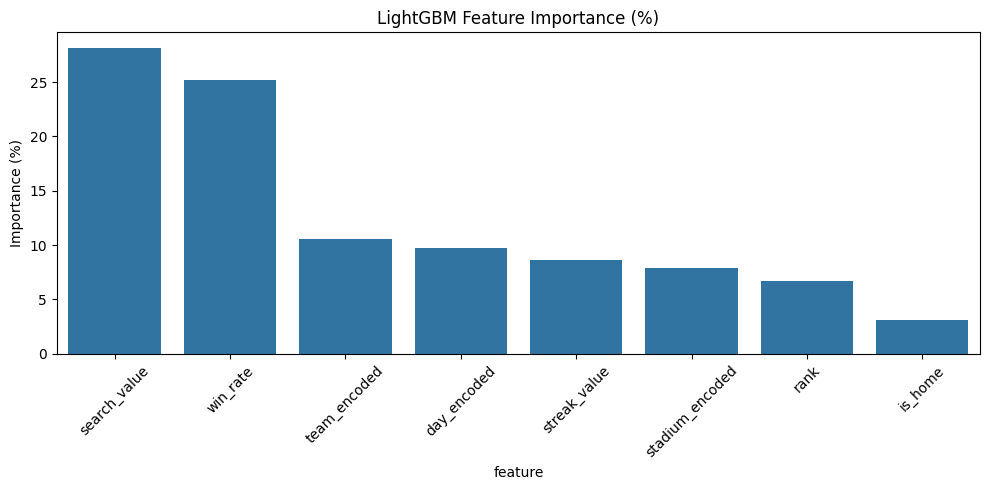

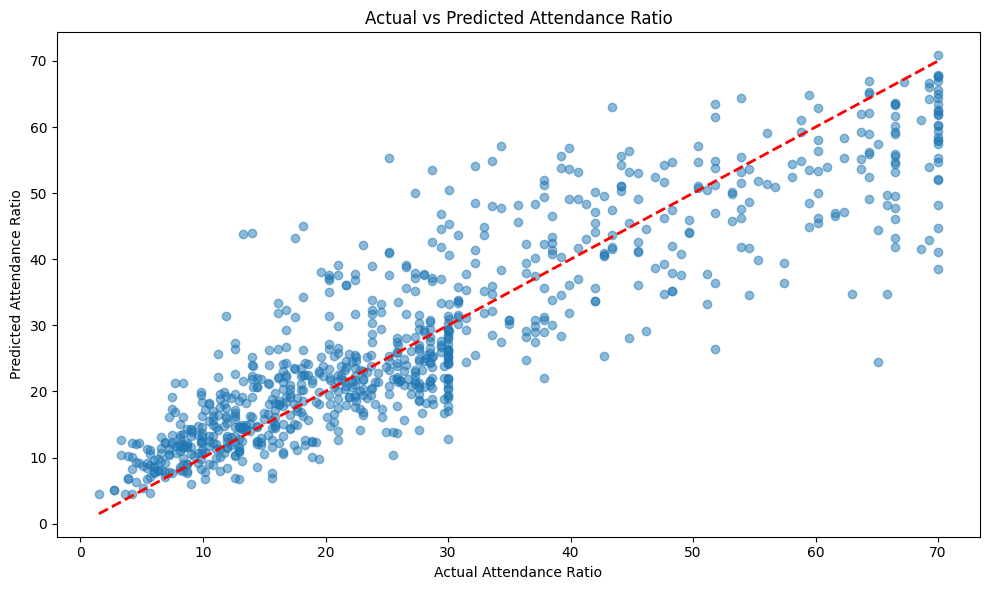

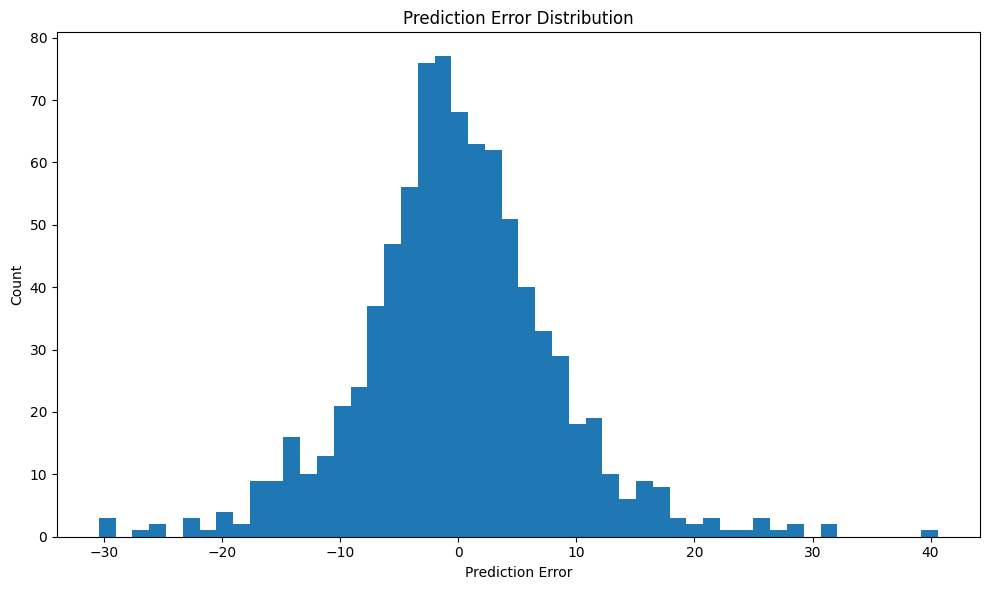


=== LightGBM 모델 분석 결과 ===

RMSE: 8.39
R² Score: 0.783

=== 예측 오차 통계 ===
평균 오차: -0.04
오차 표준편차: 8.39
최대 오차: 40.63

=== 특성 중요도 순위 ===
search_value: 28.17%
win_rate: 25.17%
team_encoded: 10.57%
day_encoded: 9.73%
streak_value: 8.60%
stadium_encoded: 7.93%
rank: 6.73%
is_home: 3.10%


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_expected_attendance_ratio(df):
    """전체 데이터프레임에 대해 expected_attendance_ratio를 계산"""
    df['expected_attendance_ratio'] = np.nan

    for date in df['date'].unique():
        date_games = df[df['date'] == date]

        for stadium in date_games['stadium'].dropna().unique():
            stadium_games = date_games[date_games['stadium'] == stadium]

            home_game = stadium_games[stadium_games['home_or_away'] == 'home']
            if len(home_game) > 0:
                total_ratio = home_game['attendance_ratio'].iloc[0]

                # 홈팀 비율 설정 (전체의 70%)
                home_ratio = total_ratio * 0.7
                # 원정팀 비율 설정 (전체의 30%)
                away_ratio = total_ratio * 0.3

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'home'),
                      'expected_attendance_ratio'] = home_ratio

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'away'),
                      'expected_attendance_ratio'] = away_ratio

    return df

def analyze_lightgbm_model(df, features):
    # 데이터 준비
    X = df[features]
    y = df['expected_attendance_ratio']

    # 학습/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # LightGBM 모델 학습
    model = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    model.fit(X_train_scaled, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_test_scaled)
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

    # 특성 중요도를 퍼센트로 변환
    importance_values = model.feature_importances_
    importance_percentages = (importance_values / importance_values.sum()) * 100

    importances = pd.DataFrame({
        'feature': features,
        'importance': importance_percentages
    }).sort_values('importance', ascending=False)

    # 특성 중요도 시각화 - 퍼센트로 표시
    plt.figure(figsize=(10, 5))
    sns.barplot(x='feature', y='importance', data=importances)
    plt.title('LightGBM Feature Importance (%)')
    plt.ylabel('Importance (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 실제값과 예측값 비교 산점도
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Attendance Ratio')
    plt.ylabel('Predicted Attendance Ratio')
    plt.title('Actual vs Predicted Attendance Ratio')
    plt.tight_layout()
    plt.show()

    # 예측 오차 분포
    plt.figure(figsize=(10, 6))
    error = y_test - y_pred
    plt.hist(error, bins=50)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    return model, importances, rmse, r2, error

def preprocess_data(df):
    print("\n=== 데이터 전처리 현황 ===")
    print(f"원본 데이터: {len(df)}행")

    # 월요일 데이터 제외
    df = df[df['day'] != '월']
    print(f"월요일 제외 후: {len(df)}행")

    # 새로운 관중 비율 계산
    df = calculate_expected_attendance_ratio(df)

    # NULL 제거
    df = df.dropna(subset=['expected_attendance_ratio'])
    print(f"NULL 제외 후: {len(df)}행")

    # 범주형 변수 전처리
    le = LabelEncoder()
    df['day_encoded'] = le.fit_transform(df['day'])
    df['team_encoded'] = le.fit_transform(df['team'])
    df['stadium_encoded'] = le.fit_transform(df['stadium'])

    # 연승/연패 수치 변환
    df['streak_value'] = df['streak'].apply(lambda x:
        int(x[:-1]) if x.endswith('승') else -int(x[:-1]))

    # home/away 더미 변수화
    df['is_home'] = (df['home_or_away'] == 'home').astype(int)

    return df

def print_model_insights(importances, rmse, r2, error):
    print("\n=== LightGBM 모델 분석 결과 ===")
    print(f"\nRMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.3f}")

    print("\n=== 예측 오차 통계 ===")
    print(f"평균 오차: {np.mean(error):.2f}")
    print(f"오차 표준편차: {np.std(error):.2f}")
    print(f"최대 오차: {np.max(np.abs(error)):.2f}")

    print("\n=== 특성 중요도 순위 ===")
    for idx, row in importances.iterrows():
        print(f"{row['feature']}: {row['importance']:.2f}%")

def main():
    # 데이터 로드
    df = pd.read_csv('24KBO데이터최종종.csv')

    # 전처리
    df = preprocess_data(df)

    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    # LightGBM 모델 분석
    model, importances, rmse, r2, error = analyze_lightgbm_model(df, features)

    # 결과 출력
    print_model_insights(importances, rmse, r2, error)

if __name__ == "__main__":
    main()


=== 데이터 전처리 현황 ===
원본 데이터: 4895행
월요일 제외 후: 4847행


<ipython-input-1-f71f03c85b8f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expected_attendance_ratio'] = np.nan


NULL 제외 후: 4228행


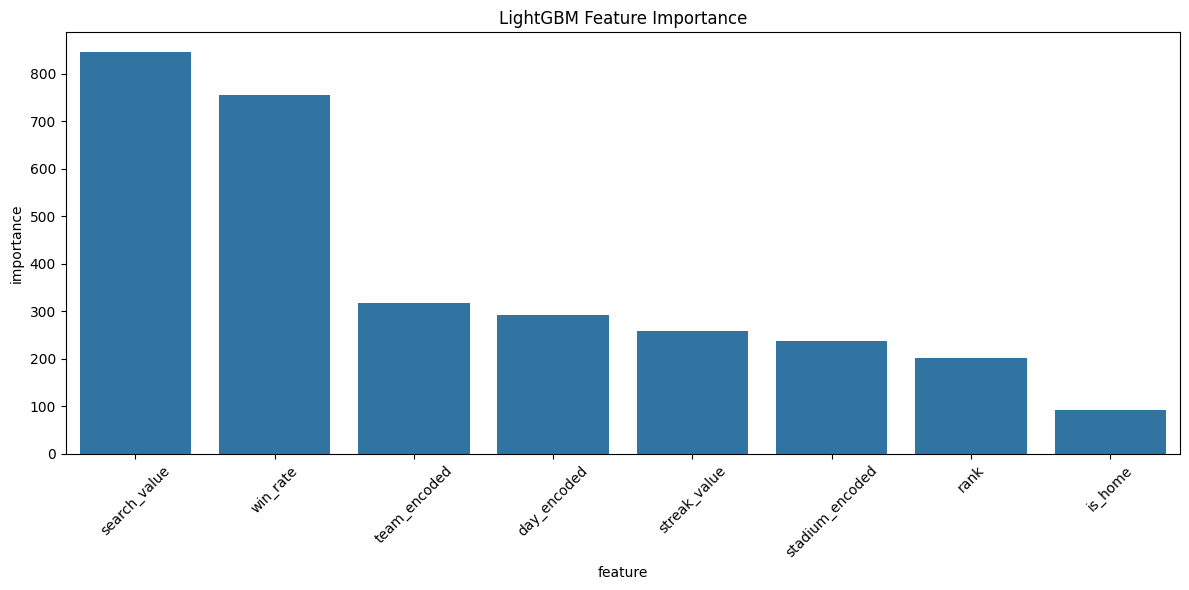

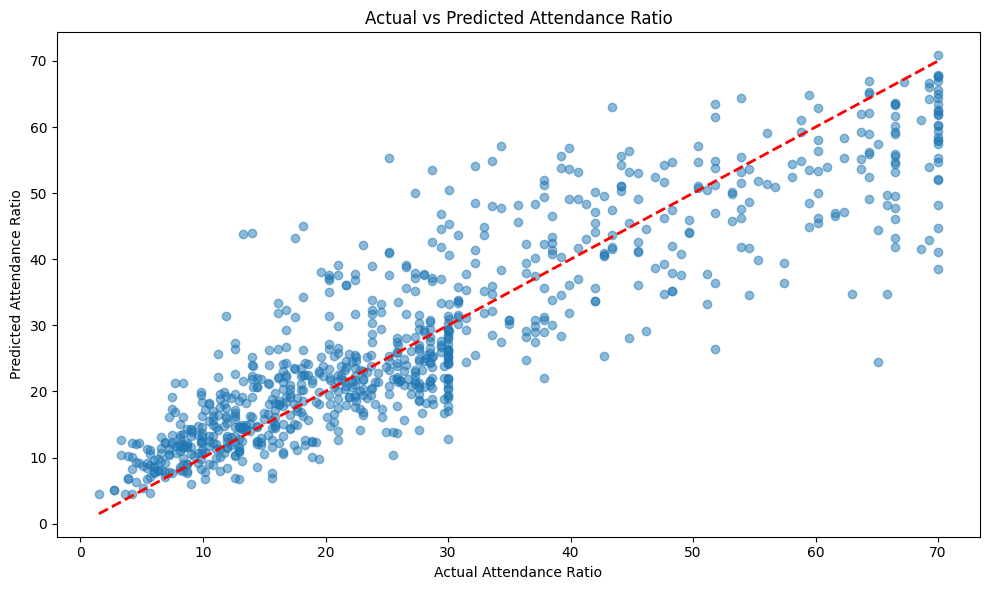

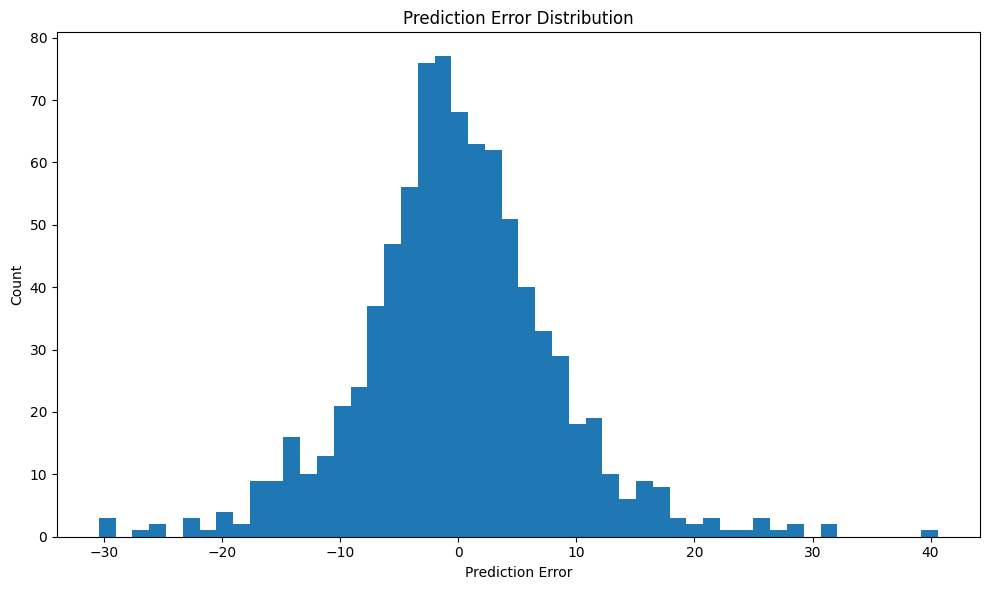


=== LightGBM 모델 분석 결과 ===

RMSE: 8.39
R² Score: 0.783

=== 예측 오차 통계 ===
평균 오차: -0.04
오차 표준편차: 8.39
최대 오차: 40.63

=== 특성 중요도 순위 ===
search_value: 28.17%
win_rate: 25.17%
team_encoded: 10.57%
day_encoded: 9.73%
streak_value: 8.60%
stadium_encoded: 7.93%
rank: 6.73%
is_home: 3.10%


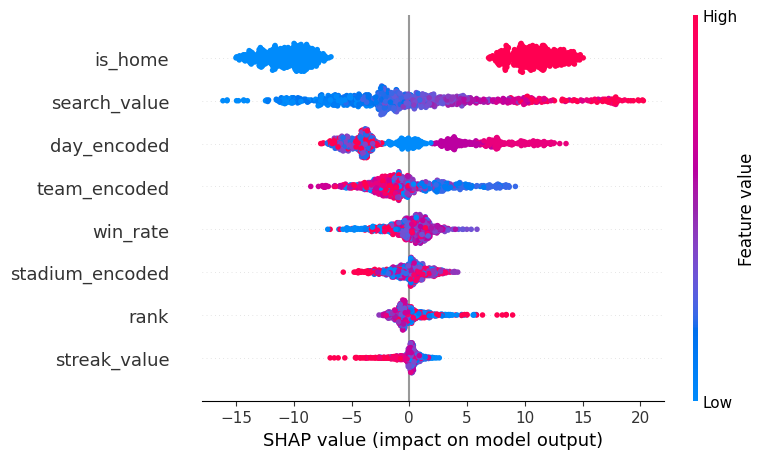

<Figure size 1000x600 with 0 Axes>

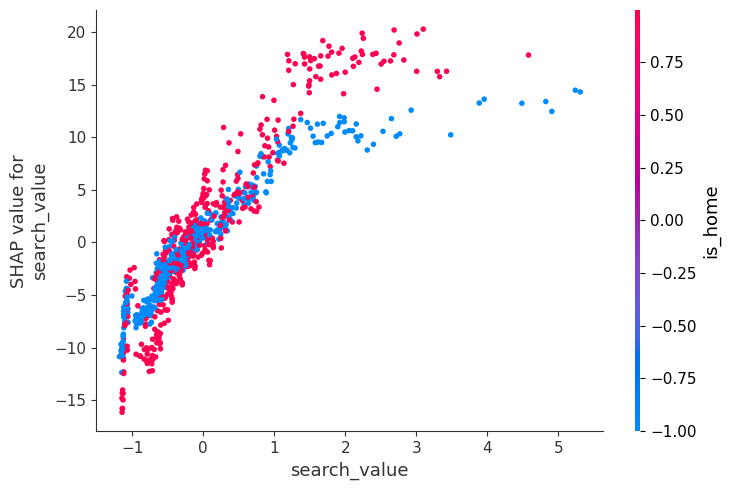

In [ ]:
import shap  # SHAP 라이브러리 임포트

def analyze_shap_values(model, X_test_scaled, features):
    """
    SHAP 값을 계산하고 시각화합니다.
    """
    # SHAP 값을 계산하기 위한 TreeExplainer 생성
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled)

    # SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_scaled, feature_names=features, show=False)
    plt.tight_layout()
    plt.show()

    # SHAP dependence plot (특정 중요한 특성 선택)
    top_feature = features[np.argmax(model.feature_importances_)]
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(top_feature, shap_values, X_test_scaled, feature_names=features, show=False)
    plt.tight_layout()
    plt.show()

    return shap_values

def main():
    # 데이터 로드
    df = pd.read_csv('24KBO데이터최종종.csv')

    # 전처리
    df = preprocess_data(df)

    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    # 데이터 준비
    X = df[features]
    y = df['expected_attendance_ratio']

    # 데이터 분할 및 스케일링
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # LightGBM 모델 분석
    model, importances, rmse, r2, error = analyze_lightgbm_model(df, features)

    # 결과 출력
    print_model_insights(importances, rmse, r2, error)

    # SHAP 값 분석
    shap_values = analyze_shap_values(model, X_test_scaled, features)

if __name__ == "__main__":
    main()



=== 데이터 전처리 현황 ===
원본 데이터: 4895행
월요일 제외 후: 4847행


<ipython-input-10-cc364bccdb01>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expected_attendance_ratio'] = np.nan


NULL 제외 후: 4228행


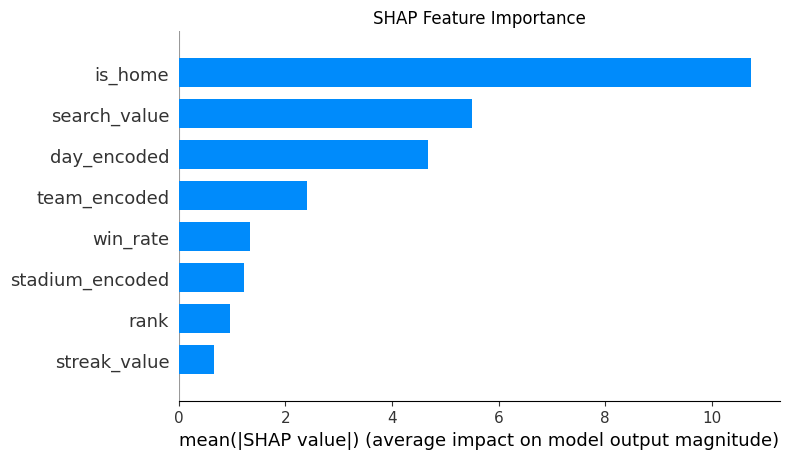

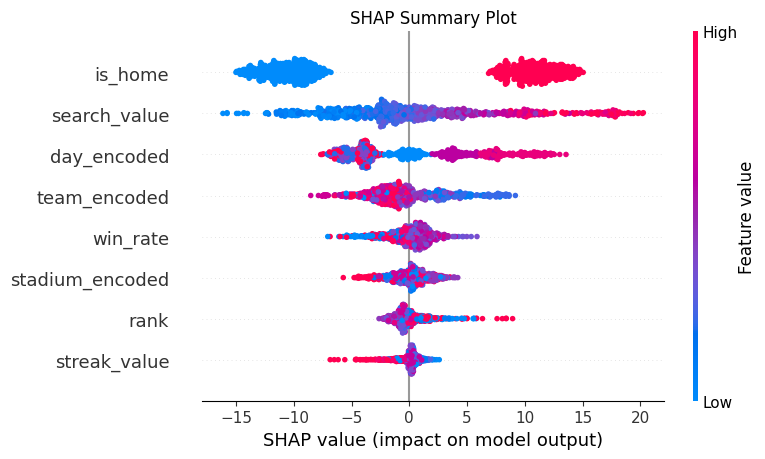

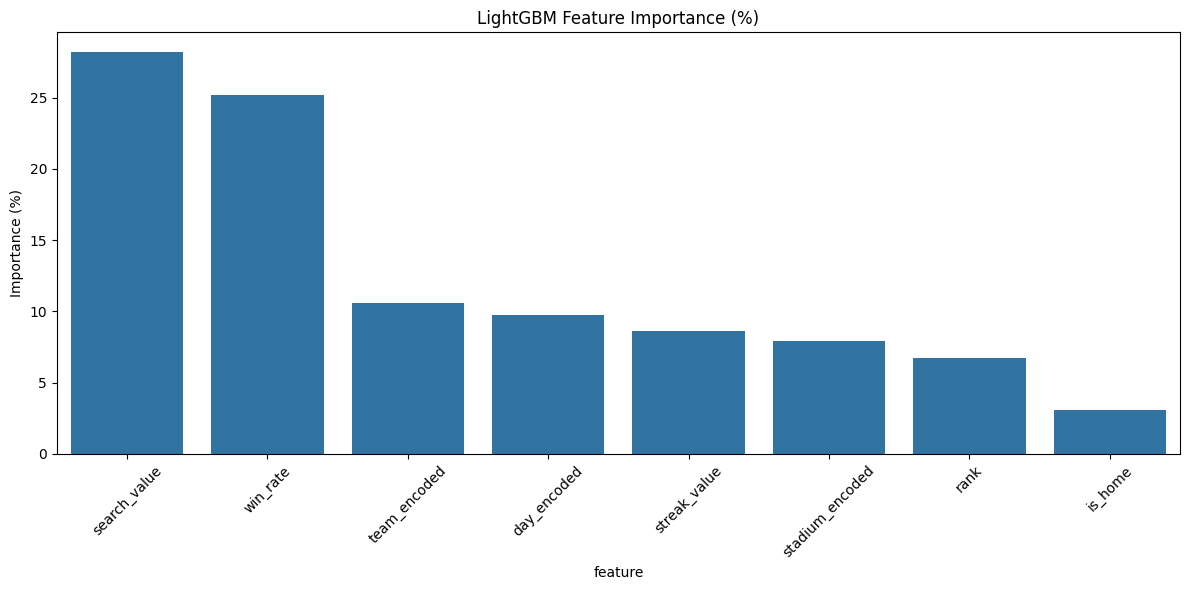

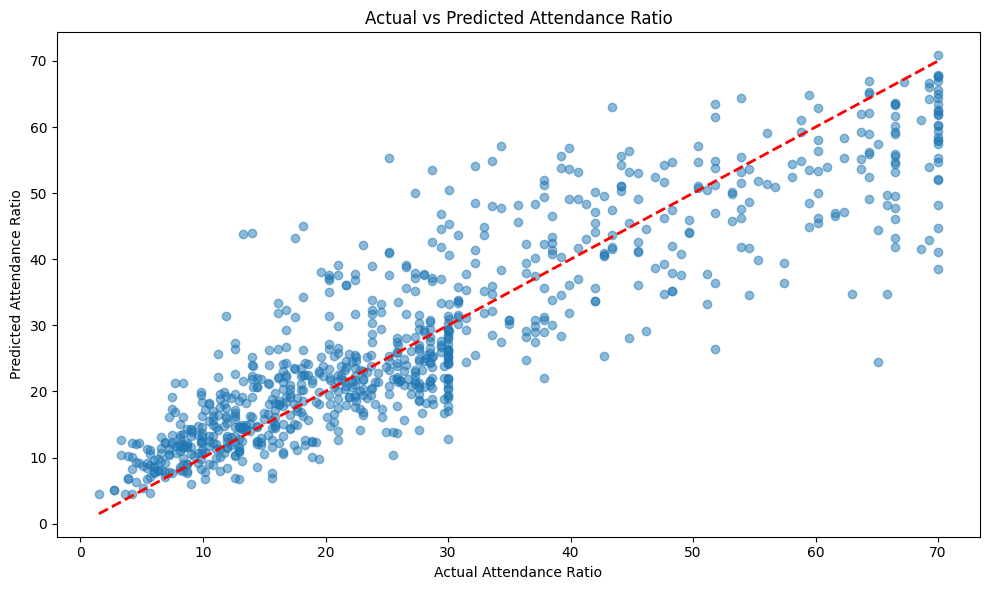

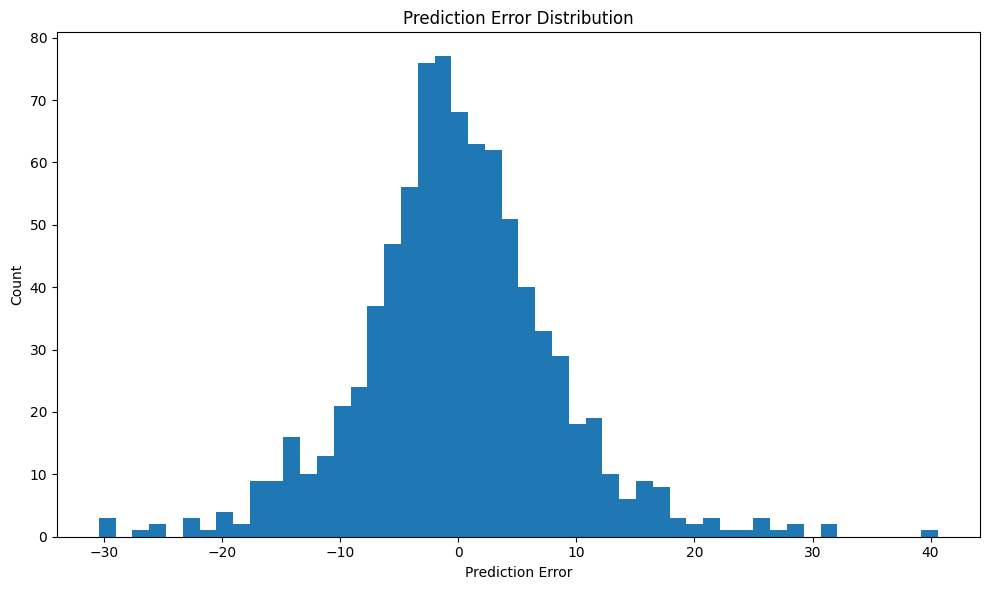

<Figure size 1000x600 with 0 Axes>

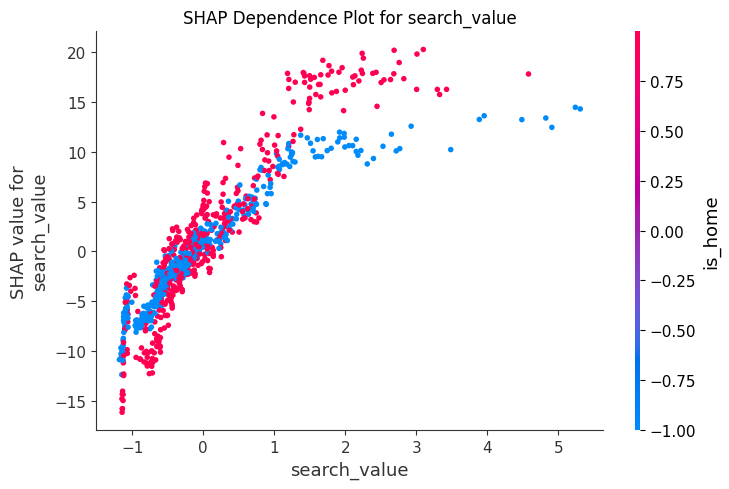


=== LightGBM 모델 분석 결과 ===

RMSE: 8.39
R² Score: 0.783

=== 예측 오차 통계 ===
평균 오차: -0.04
오차 표준편차: 8.39
최대 오차: 40.63

=== 특성 중요도 순위 ===
search_value: 28.17%
win_rate: 25.17%
team_encoded: 10.57%
day_encoded: 9.73%
streak_value: 8.60%
stadium_encoded: 7.93%
rank: 6.73%
is_home: 3.10%


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import shap

def calculate_expected_attendance_ratio(df):
    """전체 데이터프레임에 대해 expected_attendance_ratio를 계산"""
    df['expected_attendance_ratio'] = np.nan

    for date in df['date'].unique():
        date_games = df[df['date'] == date]

        for stadium in date_games['stadium'].dropna().unique():
            stadium_games = date_games[date_games['stadium'] == stadium]

            home_game = stadium_games[stadium_games['home_or_away'] == 'home']
            if len(home_game) > 0:
                total_ratio = home_game['attendance_ratio'].iloc[0]

                # 홈팀 비율 설정 (전체의 70%)
                home_ratio = total_ratio * 0.7
                # 원정팀 비율 설정 (전체의 30%)
                away_ratio = total_ratio * 0.3

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'home'),
                      'expected_attendance_ratio'] = home_ratio

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'away'),
                      'expected_attendance_ratio'] = away_ratio

    return df

def analyze_lightgbm_model(df, features):
    # 데이터 준비
    X = df[features]
    y = df['expected_attendance_ratio']

    # 학습/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # DataFrame으로 변환 (SHAP 분석을 위해)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

    # LightGBM 모델 학습
    model = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    model.fit(X_train_scaled, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_test_scaled)
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

    # 특성 중요도를 퍼센트로 변환
    importance_values = model.feature_importances_
    importance_percentages = (importance_values / importance_values.sum()) * 100

    importances = pd.DataFrame({
        'feature': features,
        'importance': importance_percentages
    }).sort_values('importance', ascending=False)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled_df)

    # SHAP 시각화
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_scaled_df, show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()

    # 특성 중요도 시각화 - 퍼센트로 표시
    plt.figure(figsize=(12, 6))
    sns.barplot(x='feature', y='importance', data=importances)
    plt.title('LightGBM Feature Importance (%)')
    plt.ylabel('Importance (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 실제값과 예측값 비교 산점도
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Attendance Ratio')
    plt.ylabel('Predicted Attendance Ratio')
    plt.title('Actual vs Predicted Attendance Ratio')
    plt.tight_layout()
    plt.show()

    # 예측 오차 분포
    plt.figure(figsize=(10, 6))
    error = y_test - y_pred
    plt.hist(error, bins=50)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # SHAP 의존성 플롯 (가장 중요한 특성에 대해)
    most_important_feature = importances.iloc[0]['feature']
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(most_important_feature, shap_values, X_test_scaled_df, show=False)
    plt.title(f'SHAP Dependence Plot for {most_important_feature}')
    plt.tight_layout()
    plt.show()

    return model, importances, rmse, r2, error, shap_values, X_test_scaled_df

def preprocess_data(df):
    print("\n=== 데이터 전처리 현황 ===")
    print(f"원본 데이터: {len(df)}행")

    # 월요일 데이터 제외
    df = df[df['day'] != '월']
    print(f"월요일 제외 후: {len(df)}행")

    # 새로운 관중 비율 계산
    df = calculate_expected_attendance_ratio(df)

    # NULL 제거
    df = df.dropna(subset=['expected_attendance_ratio'])
    print(f"NULL 제외 후: {len(df)}행")

    # 범주형 변수 전처리
    le = LabelEncoder()
    df['day_encoded'] = le.fit_transform(df['day'])
    df['team_encoded'] = le.fit_transform(df['team'])
    df['stadium_encoded'] = le.fit_transform(df['stadium'])

    # 연승/연패 수치 변환
    df['streak_value'] = df['streak'].apply(lambda x:
        int(x[:-1]) if x.endswith('승') else -int(x[:-1]))

    # home/away 더미 변수화
    df['is_home'] = (df['home_or_away'] == 'home').astype(int)

    return df

def print_model_insights(importances, rmse, r2, error):
    print("\n=== LightGBM 모델 분석 결과 ===")
    print(f"\nRMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.3f}")

    print("\n=== 예측 오차 통계 ===")
    print(f"평균 오차: {np.mean(error):.2f}")
    print(f"오차 표준편차: {np.std(error):.2f}")
    print(f"최대 오차: {np.max(np.abs(error)):.2f}")

    print("\n=== 특성 중요도 순위 ===")
    for idx, row in importances.iterrows():
        print(f"{row['feature']}: {row['importance']:.2f}%")

def main():
    # 데이터 로드
    df = pd.read_csv('24KBO데이터최종종.csv')

    # 전처리
    df = preprocess_data(df)

    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    # LightGBM 모델 분석
    model, importances, rmse, r2, error, shap_values, X_test_df = analyze_lightgbm_model(df, features)

    # 결과 출력
    print_model_insights(importances, rmse, r2, error)

if __name__ == "__main__":
    main()


=== 데이터 전처리 현황 ===
원본 데이터: 4895행
월요일 제외 후: 4847행


<ipython-input-20-d341d91ba668>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expected_attendance_ratio'] = np.nan


NULL 제외 후: 4228행


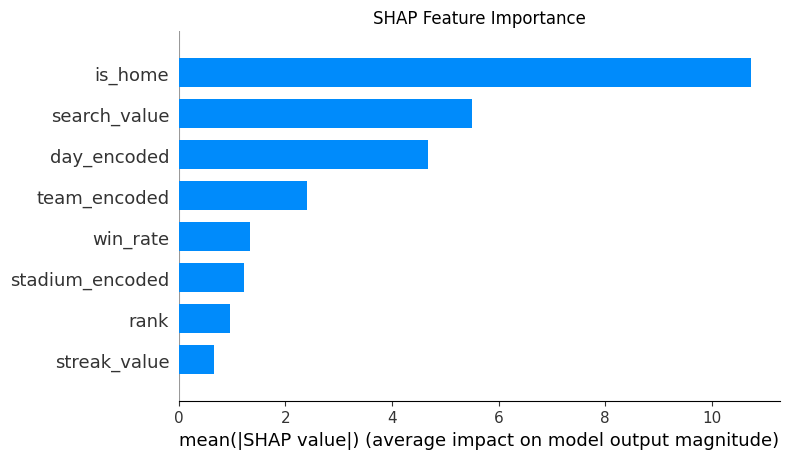

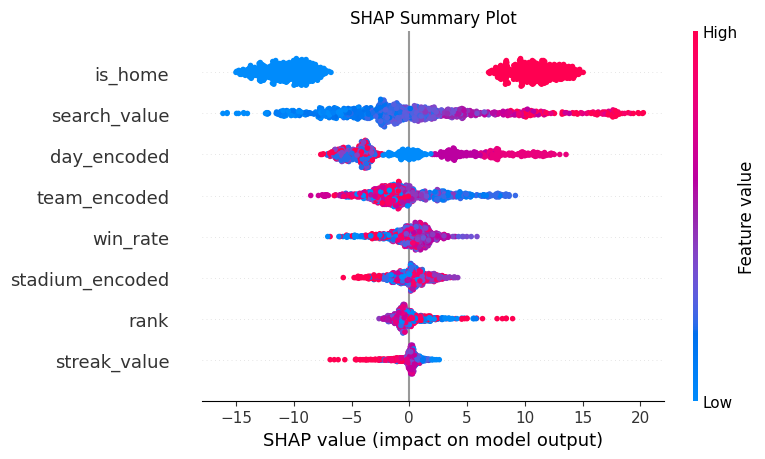

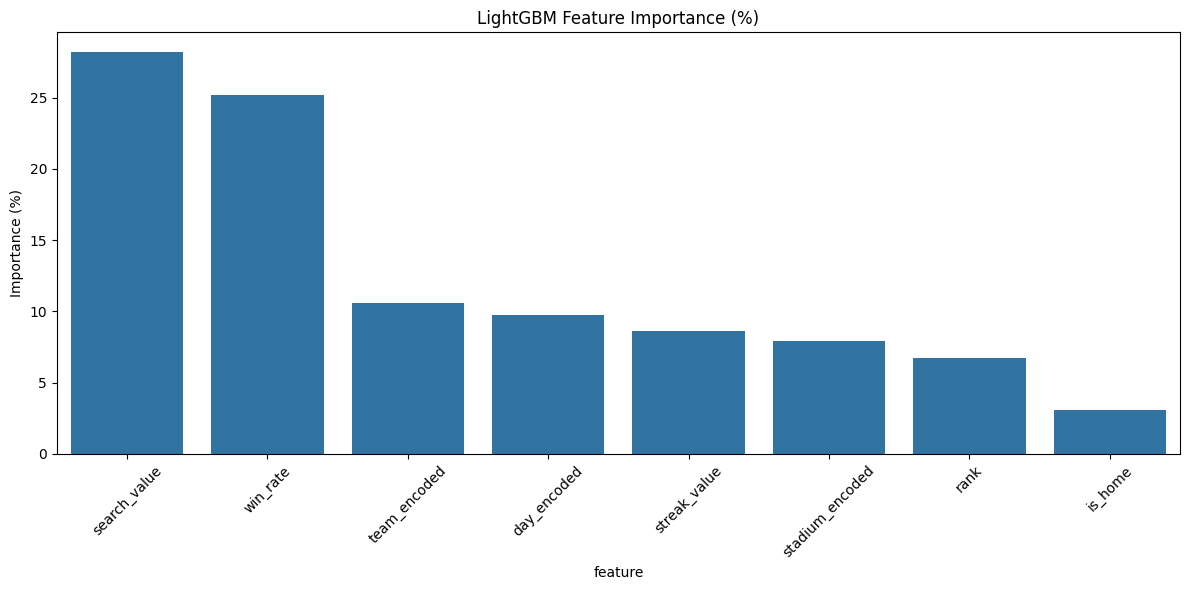

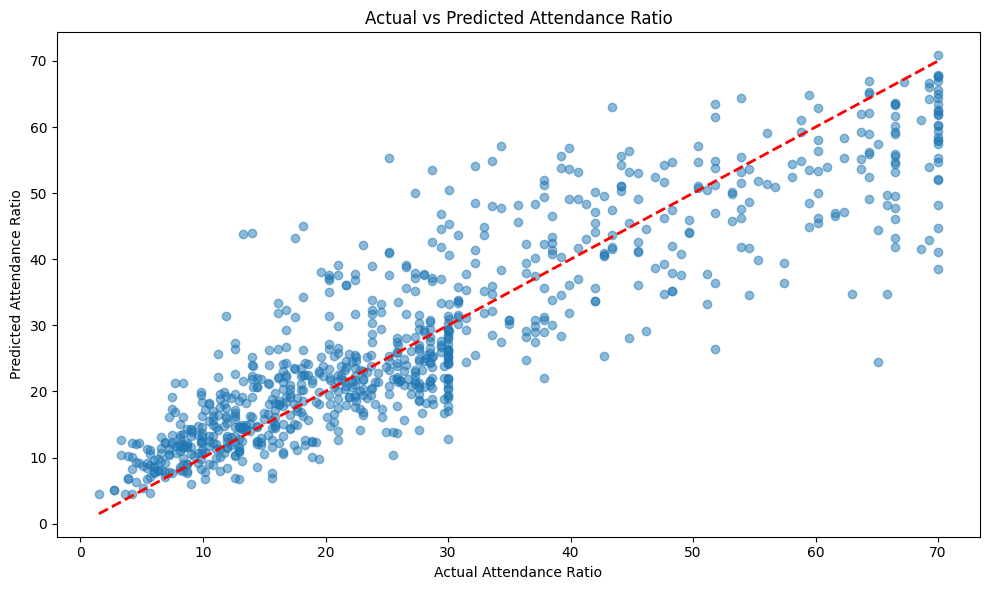

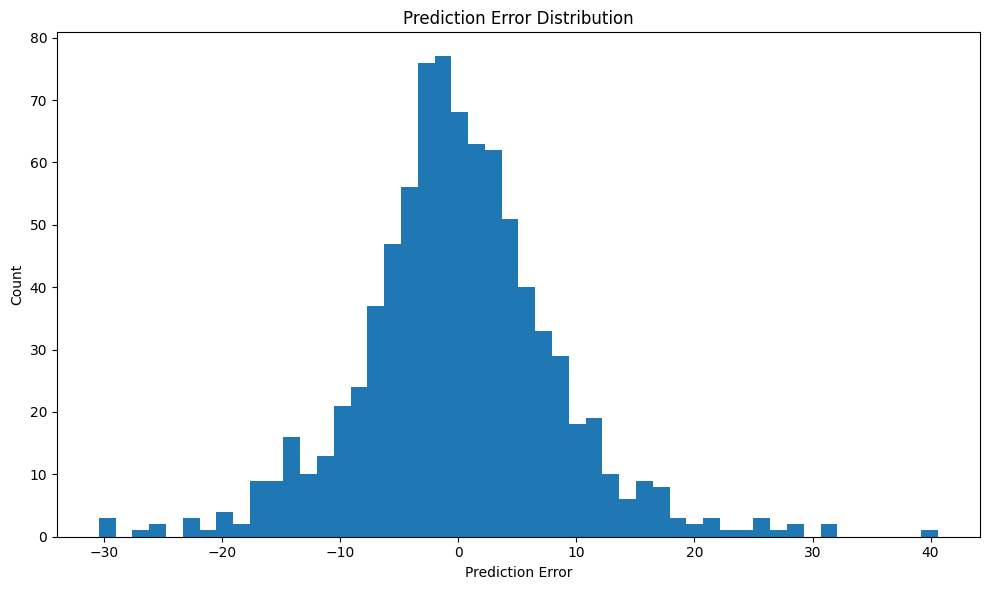

<Figure size 1000x600 with 0 Axes>

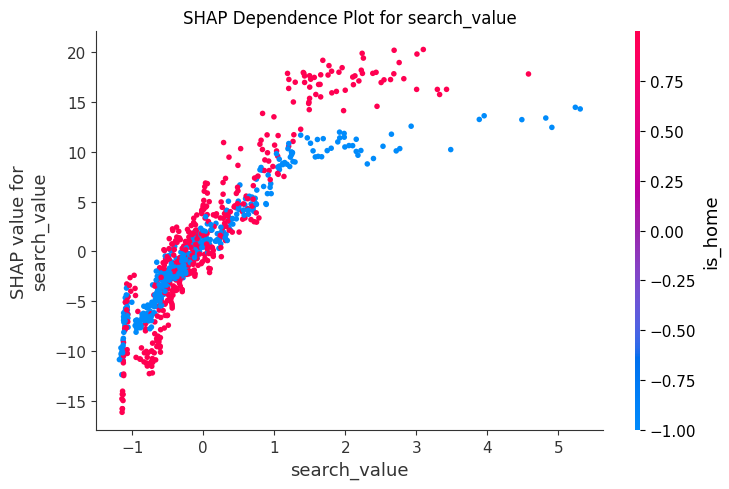


=== LightGBM 모델 분석 결과 ===

RMSE: 8.39
R² Score: 0.783

=== 예측 오차 통계 ===
평균 오차: -0.04
오차 표준편차: 8.39
최대 오차: 40.63

=== 특성 중요도 순위 ===
search_value: 28.17%
win_rate: 25.17%
team_encoded: 10.57%
day_encoded: 9.73%
streak_value: 8.60%
stadium_encoded: 7.93%
rank: 6.73%
is_home: 3.10%

=== SHAP 분석 결과 ===

특성별 평균 절대 SHAP 값 (중요도 순):
is_home: 39.09% (양의 영향)
search_value: 20.02% (양의 영향)
day_encoded: 16.98% (양의 영향)
team_encoded: 8.74% (음의 영향)
win_rate: 4.86% (양의 영향)
stadium_encoded: 4.42% (양의 영향)
rank: 3.50% (음의 영향)
streak_value: 2.39% (음의 영향)

특성별 SHAP 값 통계:

rank:
  평균: -0.0174
  표준편차: 1.4177
  최소값: -2.6213
  최대값: 8.9398

win_rate:
  평균: 0.0776
  표준편차: 1.7567
  최소값: -7.0600
  최대값: 5.8587

streak_value:
  평균: -0.0583
  표준편차: 1.0618
  최소값: -6.8494
  최대값: 2.5938

search_value:
  평균: 0.5365
  표준편차: 7.2153
  최소값: -16.1331
  최대값: 20.2574

day_encoded:
  평균: 0.0794
  표준편차: 5.4225
  최소값: -7.6662
  최대값: 13.5653

team_encoded:
  평균: -0.3574
  표준편차: 3.0572
  최소값: -8.5308
  최대값: 9.1802

stadium_encoded:
  

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import shap

def analyze_shap_values(shap_values, X_test_df):
    """SHAP 값 분석을 위한 함수"""
    # 각 특성별 평균 절대 SHAP 값 계산
    mean_abs_shap = pd.DataFrame({
        'feature': X_test_df.columns,
        'mean_abs_shap': np.abs(shap_values).mean(0),
        'mean_shap': shap_values.mean(0)  # 방향성 확인을 위한 평균 SHAP 값
    })

    # 결과 정렬
    mean_abs_shap = mean_abs_shap.sort_values('mean_abs_shap', ascending=False)

    # 각 특성별 SHAP 값 분포 통계
    shap_stats = {}
    for feature in X_test_df.columns:
        feature_shap = shap_values[:, X_test_df.columns.get_loc(feature)]
        shap_stats[feature] = {
            'mean': np.mean(feature_shap),
            'std': np.std(feature_shap),
            'min': np.min(feature_shap),
            'max': np.max(feature_shap)
        }

    return mean_abs_shap, shap_stats

# analyze_lightgbm_model 함수 내에 다음 코드 추가 (return 문 직전에)


def calculate_expected_attendance_ratio(df):
    """전체 데이터프레임에 대해 expected_attendance_ratio를 계산"""
    df['expected_attendance_ratio'] = np.nan

    for date in df['date'].unique():
        date_games = df[df['date'] == date]

        for stadium in date_games['stadium'].dropna().unique():
            stadium_games = date_games[date_games['stadium'] == stadium]

            home_game = stadium_games[stadium_games['home_or_away'] == 'home']
            if len(home_game) > 0:
                total_ratio = home_game['attendance_ratio'].iloc[0]

                # 홈팀 비율 설정 (전체의 70%)
                home_ratio = total_ratio * 0.7
                # 원정팀 비율 설정 (전체의 30%)
                away_ratio = total_ratio * 0.3

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'home'),
                      'expected_attendance_ratio'] = home_ratio

                df.loc[(df['date'] == date) &
                      (df['stadium'] == stadium) &
                      (df['home_or_away'] == 'away'),
                      'expected_attendance_ratio'] = away_ratio

    return df

def analyze_lightgbm_model(df, features):
    # 데이터 준비
    X = df[features]
    y = df['expected_attendance_ratio']

    # 학습/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # DataFrame으로 변환 (SHAP 분석을 위해)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

    # LightGBM 모델 학습
    model = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    model.fit(X_train_scaled, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_test_scaled)
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

    # 특성 중요도를 퍼센트로 변환
    importance_values = model.feature_importances_
    importance_percentages = (importance_values / importance_values.sum()) * 100

    importances = pd.DataFrame({
        'feature': features,
        'importance': importance_percentages
    }).sort_values('importance', ascending=False)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled_df)


    mean_abs_shap, shap_stats = analyze_shap_values(shap_values, X_test_scaled_df)

    # SHAP 시각화
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_scaled_df, show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()

    # 특성 중요도 시각화 - 퍼센트로 표시
    plt.figure(figsize=(12, 6))
    sns.barplot(x='feature', y='importance', data=importances)
    plt.title('LightGBM Feature Importance (%)')
    plt.ylabel('Importance (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 실제값과 예측값 비교 산점도
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Attendance Ratio')
    plt.ylabel('Predicted Attendance Ratio')
    plt.title('Actual vs Predicted Attendance Ratio')
    plt.tight_layout()
    plt.show()

    # 예측 오차 분포
    plt.figure(figsize=(10, 6))
    error = y_test - y_pred
    plt.hist(error, bins=50)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # SHAP 의존성 플롯 (가장 중요한 특성에 대해)
    most_important_feature = importances.iloc[0]['feature']
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(most_important_feature, shap_values, X_test_scaled_df, show=False)
    plt.title(f'SHAP Dependence Plot for {most_important_feature}')
    plt.tight_layout()
    plt.show()


    mean_abs_shap, shap_stats = analyze_shap_values(shap_values, X_test_scaled_df)


    return model, importances, rmse, r2, error, shap_values, X_test_scaled_df, mean_abs_shap, shap_stats

def preprocess_data(df):
    print("\n=== 데이터 전처리 현황 ===")
    print(f"원본 데이터: {len(df)}행")

    # 월요일 데이터 제외
    df = df[df['day'] != '월']
    print(f"월요일 제외 후: {len(df)}행")

    # 새로운 관중 비율 계산
    df = calculate_expected_attendance_ratio(df)

    # NULL 제거
    df = df.dropna(subset=['expected_attendance_ratio'])
    print(f"NULL 제외 후: {len(df)}행")

    # 범주형 변수 전처리
    le = LabelEncoder()
    df['day_encoded'] = le.fit_transform(df['day'])
    df['team_encoded'] = le.fit_transform(df['team'])
    df['stadium_encoded'] = le.fit_transform(df['stadium'])

    # 연승/연패 수치 변환
    df['streak_value'] = df['streak'].apply(lambda x:
        int(x[:-1]) if x.endswith('승') else -int(x[:-1]))

    # home/away 더미 변수화
    df['is_home'] = (df['home_or_away'] == 'home').astype(int)

    return df

def print_model_insights(importances, rmse, r2, error):
    print("\n=== LightGBM 모델 분석 결과 ===")
    print(f"\nRMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.3f}")

    print("\n=== 예측 오차 통계 ===")
    print(f"평균 오차: {np.mean(error):.2f}")
    print(f"오차 표준편차: {np.std(error):.2f}")
    print(f"최대 오차: {np.max(np.abs(error)):.2f}")

    print("\n=== 특성 중요도 순위 ===")
    for idx, row in importances.iterrows():
        print(f"{row['feature']}: {row['importance']:.2f}%")

def print_shap_insights(mean_abs_shap, shap_stats):
    print("\n=== SHAP 분석 결과 ===")
    print("\n특성별 평균 절대 SHAP 값 (중요도 순):")
    total_abs_shap = mean_abs_shap['mean_abs_shap'].sum()
    for idx, row in mean_abs_shap.iterrows():
        percentage = (row['mean_abs_shap'] / total_abs_shap) * 100
        direction = '양의' if row['mean_shap'] > 0 else '음의'
        print(f"{row['feature']}: {percentage:.2f}% ({direction} 영향)")

    print("\n특성별 SHAP 값 통계:")
    for feature, stats in shap_stats.items():
        print(f"\n{feature}:")
        print(f"  평균: {stats['mean']:.4f}")
        print(f"  표준편차: {stats['std']:.4f}")
        print(f"  최소값: {stats['min']:.4f}")
        print(f"  최대값: {stats['max']:.4f}")

def main():
    # 데이터 로드
    df = pd.read_csv('24KBO데이터최종종.csv')

    # 전처리
    df = preprocess_data(df)

    features = ['rank', 'win_rate', 'streak_value', 'search_value',
                'day_encoded', 'team_encoded', 'stadium_encoded', 'is_home']

    # 반환값 추가
    model, importances, rmse, r2, error, shap_values, X_test_df, mean_abs_shap, shap_stats = analyze_lightgbm_model(df, features)

    # 결과 출력
    print_model_insights(importances, rmse, r2, error)
    print_shap_insights(mean_abs_shap, shap_stats)

if __name__ == "__main__":
    main()